In [1]:
import os
import sys 
import numpy as np
import matplotlib.pyplot as plt
import sys 
import mdtraj
from nglview import show_ase, show_file, show_mdtraj
import torch

from scripts.gnn_rdf_cg_water_angle import *

_ColormakerRegistry()

In [2]:
from ase.lattice.cubic import FaceCenteredCubic
from ase import units

from torchmd.system import GNNPotentials,PairPotentials,System, Stack
from torchmd.potentials import ExcludedVolume
from nff.train import get_model

size = 4
L = 4.9325
device = 2

atoms = FaceCenteredCubic(directions=[[1, 0, 0], 
                                    [0, 1, 0], 
                                    [0, 0, 1]],
                          symbol='H',
                          size=(size, size, size),
                          latticeconstant=L,
                          pbc=True)

from torchmd.system import System
system = System(atoms, device=device)
system.set_temperature(298.0)

In [16]:
cutoff = 4.0
# parameter for SchNet 
params = {
    'n_atom_basis': 64,
    'n_filters': 256,
    'n_gaussians': int(cutoff//0.196),
    'n_convolutions': 3,
    'cutoff': cutoff,
    'trainable_gauss': False
}

cutoff = params['cutoff']

# Define prior potential 
lj_params = {'epsilon': 0.0133, 
             'sigma': 2.68, 
             'power': 12}

from torchmd.system import GNNPotentials,PairPotentials,System, Stack
from torchmd.potentials import ExcludedVolume
from nff.train import get_model


pair = PairPotentials(ExcludedVolume, lj_params,
                cell=torch.Tensor(system.get_cell_len()), 
                device=device,
                cutoff=8.0,
                ).to(device)

model = get_model(params)
GNN = GNNPotentials(model, system.get_batch(), system.get_cell_len(), cutoff=params['cutoff'], device=system.device)
model = Stack({'gnn': GNN, 'pair': pair})


from torchmd.md import NoseHooverChain 
diffeq =NoseHooverChain(model, 
            system,
            Q=50.0, 
            T=298.0 * units.kB,
            num_chains=5, 
            adjoint=True).to(device)

tensor([19.7300, 19.7300, 19.7300])


In [17]:
nbins = 115
end = 7.5
tau = 63

cos_start = 0.45
cos_end = 3.1
nbins_angle_test = 128
nbins_angle_train = 128

data = np.load("../data/water_exp_pccp.npy")

In [18]:
from scipy import interpolate

def exp_angle_data(nbins, angle_range, fn='../data/water_angle_pccp.csv'):
    angle_data = np.loadtxt(fn, delimiter=',')
    # convert angle to cos(phi)
    cos = angle_data[:, 0] * np.pi / 180
    density = angle_data[:, 1]
    f = interpolate.interp1d(cos, density)
    start = angle_range[0]
    end = angle_range[1]
    xnew = np.linspace(start, end, nbins)
    density = f(xnew)
    density /= density.sum()
    
    return density

In [19]:
sim = Simulations(system, diffeq)
start = 2.0

# initialize observable function 
obs = rdf(system, nbins, (start, end) )
vacf_obs = vacf(system, t_range=int(tau))

# angle observation function 
angle_obs_train = angle_distribution(system, nbins_angle_train, (cos_start, cos_end), cutoff=3.7) # 3.25 is from the PCCP paper
angle_obs_test = angle_distribution(system, nbins_angle_test, (cos_start, cos_end), cutoff=3.7) 

# get experimental angle distribution 
cos_exp_train = exp_angle_data(nbins_angle_train, (cos_start, cos_end), fn='../data/water_angle_deepcg_3.7.csv')
cos_exp_train = torch.Tensor(cos_exp_train).to(device)
cos_exp_test = exp_angle_data(nbins_angle_test, (cos_start, cos_end), fn='../data/water_angle_deepcg_3.7.csv')
cos_exp_test = torch.Tensor(cos_exp_test).to(device)

xnew = np.linspace(start, end, nbins)
# get experimental rdf 
count_obs, g_obs = get_exp_rdf(data, nbins, (start, end), obs)
# define optimizer 
optimizer = torch.optim.Adam(list(diffeq.parameters() ), lr=0.000082)

In [20]:
def plot_angle(sim_angle, exp_angle, cos_start, cos_angle, fname, path, nbins_angle):
    bins = np.linspace(cos_start, cos_end, nbins_angle)
    plt.plot( bins * 180/np.pi, sim_angle.detach().cpu(), linewidth=4, alpha=0.6, label='sim.' )
    plt.plot( bins * 180/np.pi, exp_angle.detach().cpu(), linewidth=2,linestyle='--', c='black', label='exp.')
    plt.show()
    plt.savefig(path + '/angle_{}.jpg'.format(fname), bbox_inches='tight')
    plt.close()

In [37]:
junk = torch.Tensor([[float('nan'), 1, 1, float('nan')]])

In [38]:
torch.isnan(junk.reshape(-1)).sum()

tensor(2)

In [39]:
import math

In [42]:
loss_log = np.array([1, 1, 10, 3, 2, 1])

In [44]:
min_idx = loss_log.argmin()

std = loss_log[min_idx:-1].std()
diff = abs( loss_log[min_idx:-1].max() - loss_log[min_idx]) 

In [45]:
diff

9

In [46]:
std

3.3823069050575527

224.66824340820312


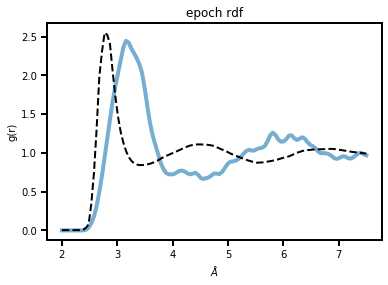

110.69503021240234


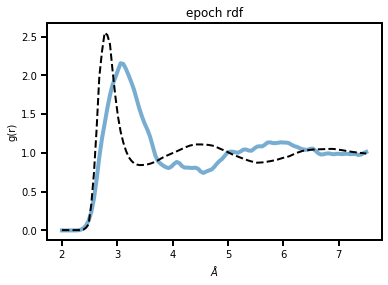

In [21]:
# First optimize for rdf 

for i in range(2):
    current_time = datetime.now() 
    trajs = sim.simulate(steps=tau, frequency=int(tau//2))
    v_t, q_t, pv_t = trajs 

    _, bins, g = obs(q_t)

    # this shoud be wrapped in some way 
    loss_js = JS_rdf(g_obs, g)
    loss = loss_js + 6.7 * (g- g_obs).pow(2).sum()# + loss_angle

    print(loss.item())
    
    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()
    
    plot_rdfs(xnew, g_obs, g, "rdf", '../examples/metadta/')

In [22]:
ANGLE_FACTOR = (cos_end - cos_start)/nbins_angle_train

0.025435157120227814 0.024505071341991425


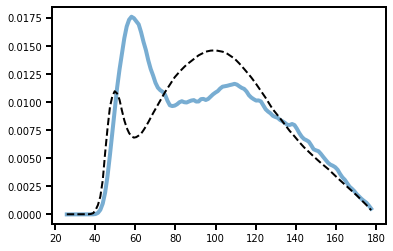

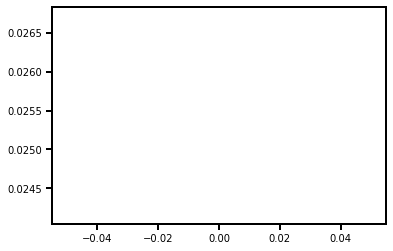

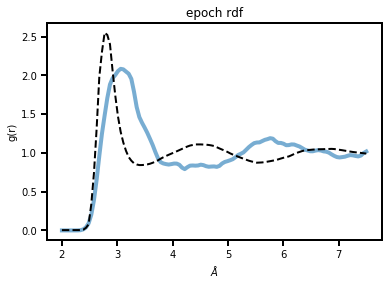

0.019741423428058624 0.02015308290719986
0.019148418679833412 0.015658164396882057
0.01856669969856739 0.013474474661052227
0.01875578612089157 0.014115724712610245
0.01701756753027439 0.010123947635293007


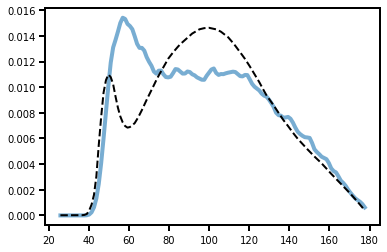

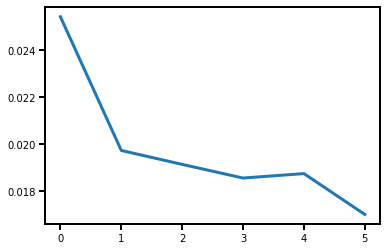

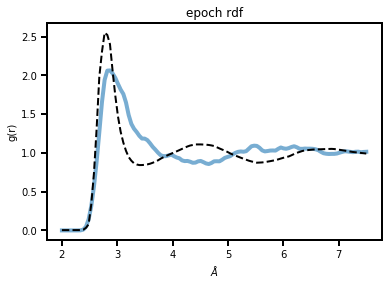

0.01612149551510811 0.00990175548940897
0.015589852817356586 0.008854088373482227
0.01803552359342575 0.007608983665704727
0.016835931688547134 0.006962410174310207
0.01492975652217865 0.006849830970168114


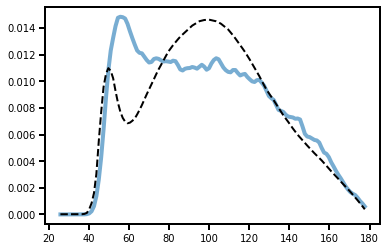

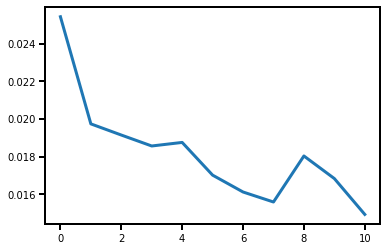

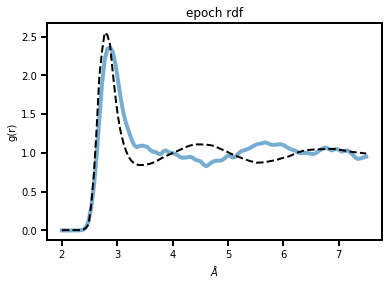

0.014502220787107944 0.0055614253506064415
0.014903262257575989 0.006166661158204079
0.016001690179109573 0.006900733802467585
0.015073482878506184 0.004585820250213146
0.012920835055410862 0.004511795938014984


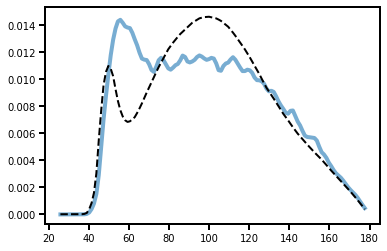

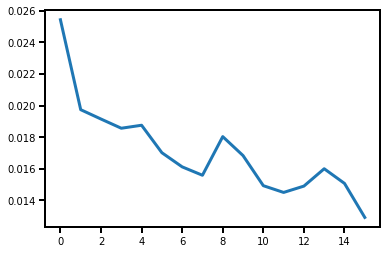

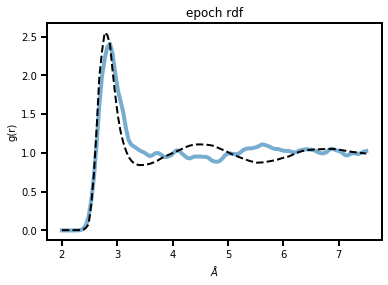

0.013269739225506783 0.0052361260168254375
0.015200024470686913 0.005728021264076233
0.014127997681498528 0.00678481999784708
0.01312845665961504 0.00440905150026083
0.012860667891800404 0.004876440390944481


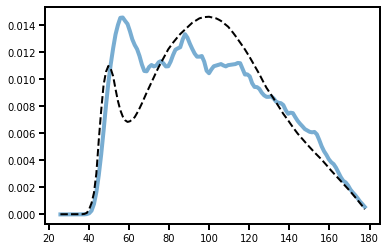

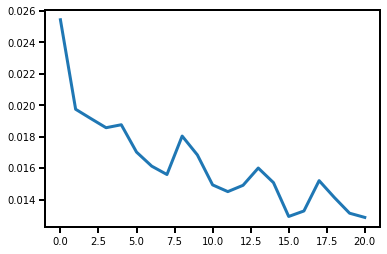

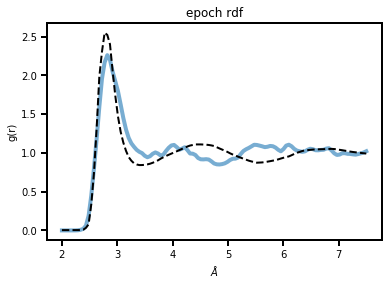

0.01196691207587719 0.0035786814987659454
0.016037870198488235 0.004307282157242298
0.015084609389305115 0.005129661411046982
0.014511195942759514 0.004116466268897057
0.01304240245372057 0.0044808099046349525


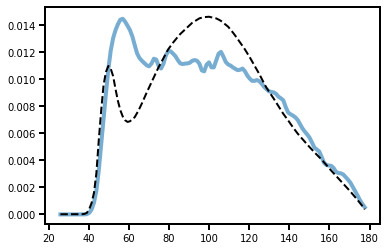

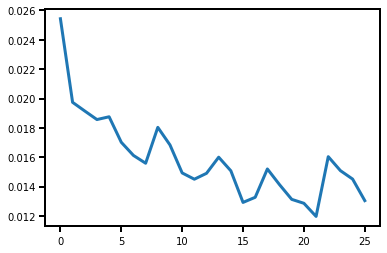

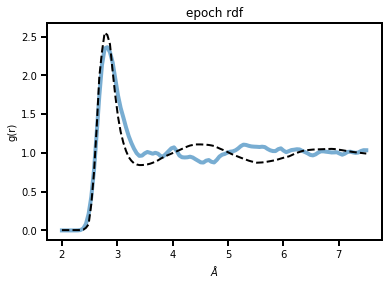

0.012542438693344593 0.004038100130856037
0.012654166668653488 0.0029091592878103256
0.01195274293422699 0.0038027316331863403
0.014692536555230618 0.005376545712351799
0.014926566742360592 0.004660516045987606


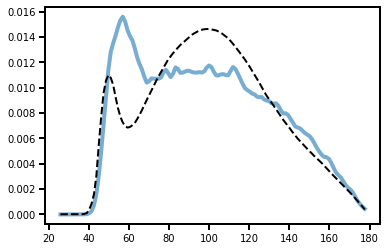

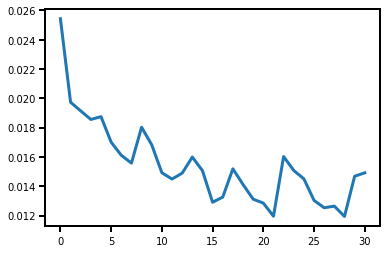

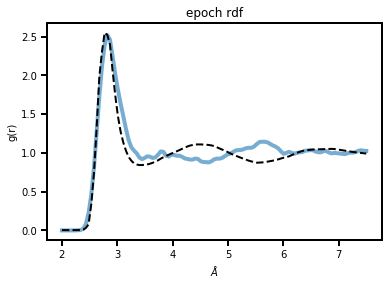

0.015438931062817574 0.004520086571574211
0.012477361597120762 0.003703352063894272
0.010525151155889034 0.0030116932466626167
0.013403663411736488 0.003713737241923809
0.016183417290449142 0.0036063436418771744


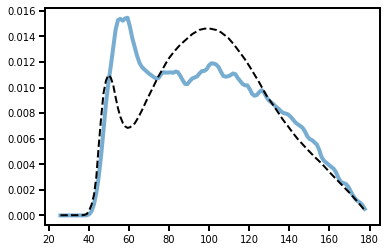

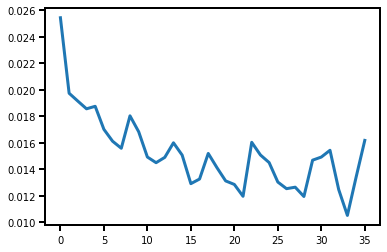

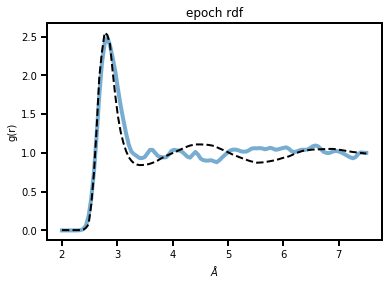

0.01440773531794548 0.0032510487362742424
0.012651817873120308 0.003598562441766262
0.01212300918996334 0.0031354939565062523
0.01228332705795765 0.0028451746329665184
0.01550489105284214 0.004106943495571613


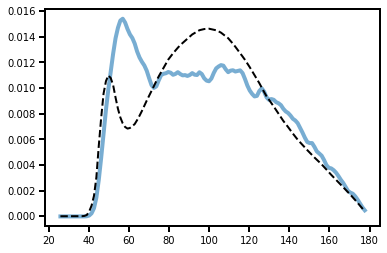

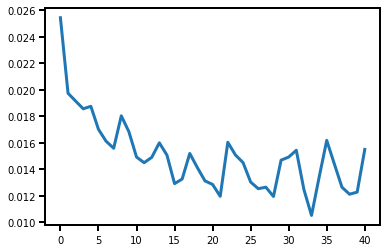

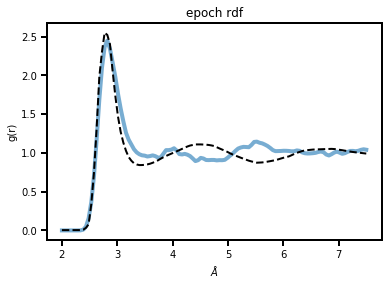

0.012994050979614258 0.004322856664657593
0.012697442434728146 0.0032722745090723038
0.013033386319875717 0.0035142162814736366
0.014896204695105553 0.003991309553384781
0.015030672773718834 0.003976071253418922


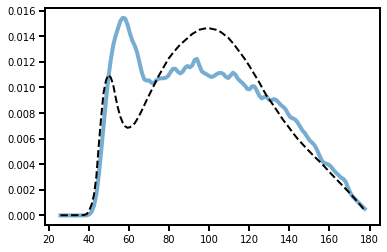

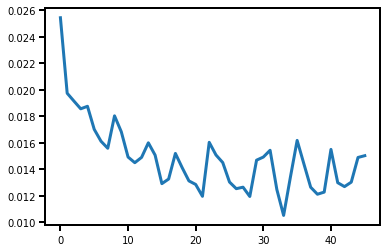

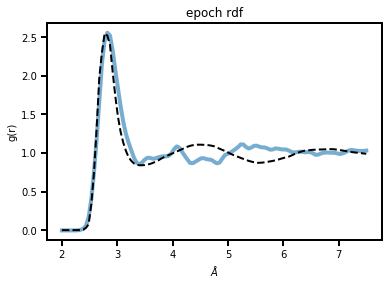

0.012718476355075836 0.0029143402352929115
0.015075921081006527 0.0029283277690410614
0.013656549155712128 0.00418130774050951
0.013268360868096352 0.0033976221457123756
0.01288868859410286 0.0027640685439109802


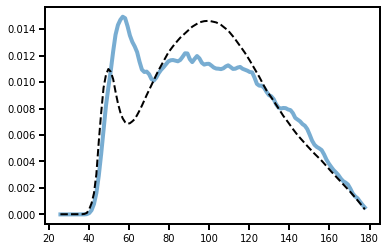

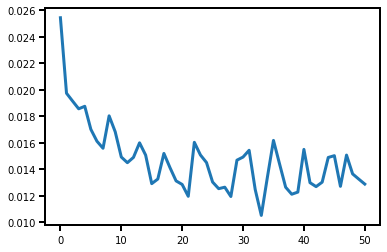

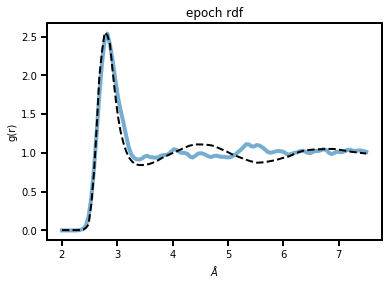

0.012750164605677128 0.002993980422616005
0.014235351234674454 0.003179982304573059
0.016480695456266403 0.00391046516597271
0.013571489602327347 0.0028509749099612236
0.012529658153653145 0.0027365628629922867


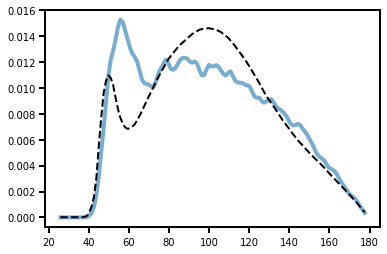

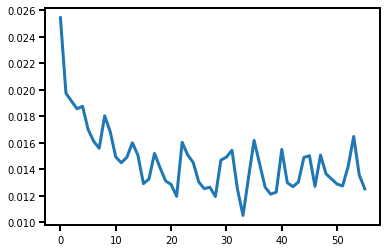

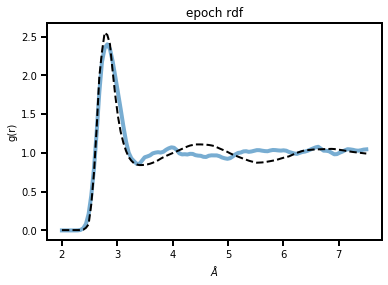

0.014387749135494232 0.0037028752267360687
0.01520216278731823 0.0030545489862561226
0.014506637118756771 0.0037695039063692093
0.012242083437740803 0.003543873317539692
0.013229528442025185 0.002190052531659603


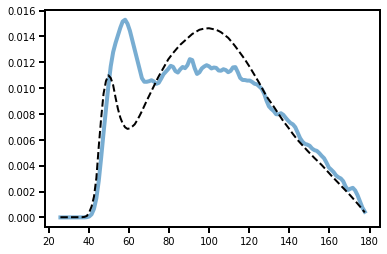

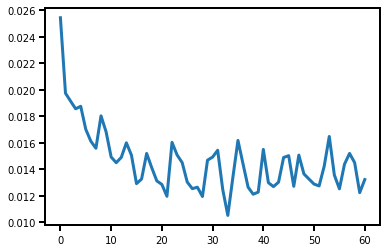

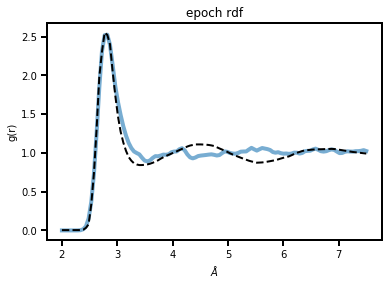

0.013739608228206635 0.003018239513039589
0.009968984872102737 0.00289171002805233
0.012229841202497482 0.0024724630638957024
0.012655344791710377 0.003784392960369587
0.014070949517190456 0.0039566317573189735


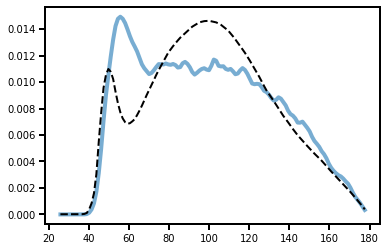

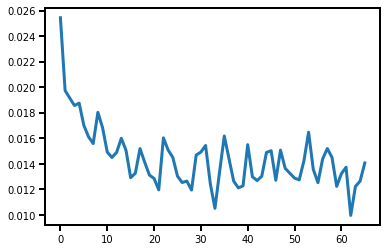

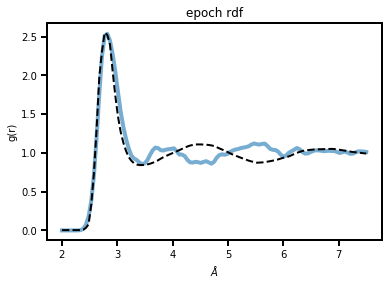

0.011334134265780449 0.003283688798546791
0.013391522690653801 0.0035978909581899643
0.012232373468577862 0.0028758998960256577
0.015821821987628937 0.004322487860918045
0.014816103503108025 0.004183358512818813


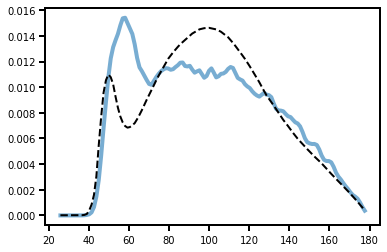

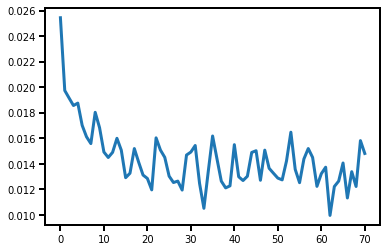

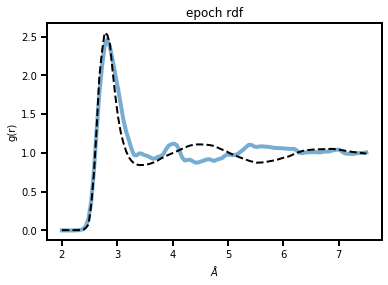

0.01249748282134533 0.003298446536064148
0.011319863609969616 0.0026221973821520805
0.011726632714271545 0.0021926192566752434
0.01384398341178894 0.0031797755509614944
0.01491334568709135 0.0031813262030482292


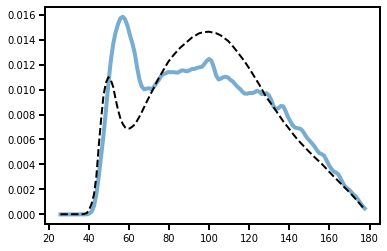

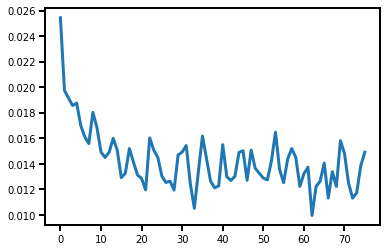

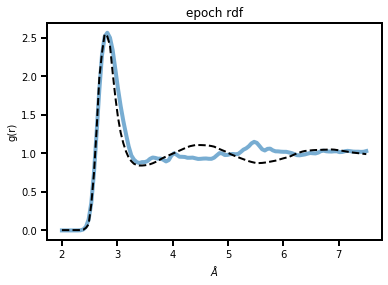

0.014451652765274048 0.004023411311209202
0.013357803225517273 0.002880984917283058
0.014081934466958046 0.0030071716755628586
0.013208219781517982 0.002944663166999817
0.012746409513056278 0.0029879342764616013


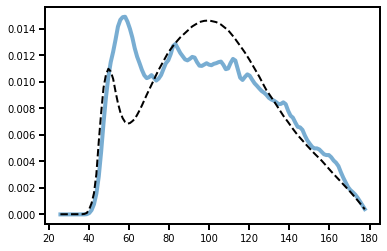

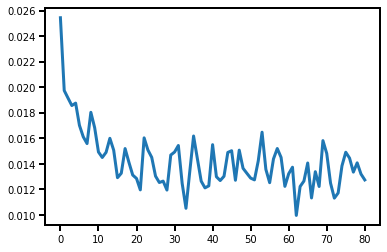

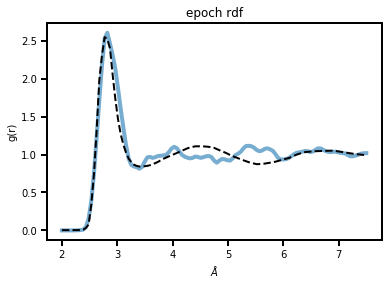

0.011526398360729218 0.00299622118473053
0.011215077713131905 0.0029602693393826485
0.012846425175666809 0.002981823869049549
0.01205664873123169 0.0034532425925135612
0.012993615120649338 0.0025738943368196487


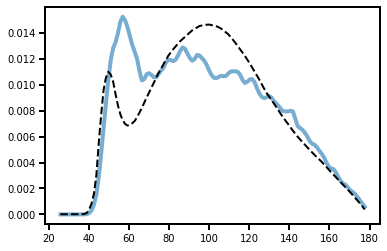

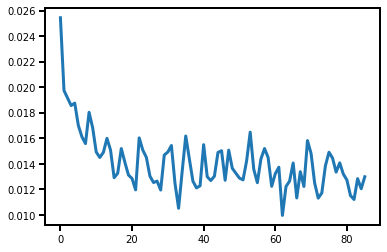

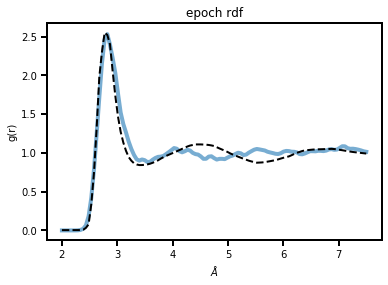

0.011966576799750328 0.0030742185190320015
0.012152677401900291 0.003101062960922718
0.014427011832594872 0.003757147118449211
0.01601332053542137 0.0036980705335736275
0.013206188566982746 0.0027344729751348495


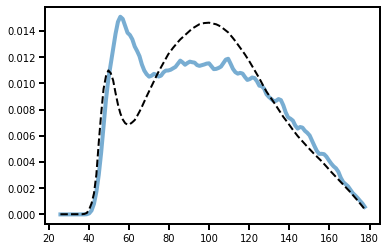

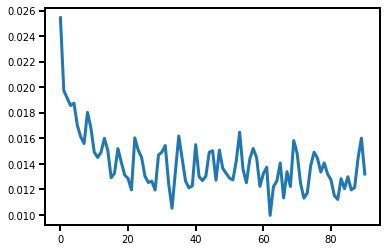

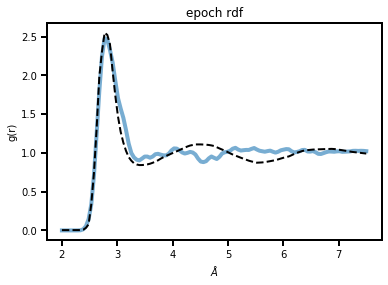

0.012627717107534409 0.002844925969839096
0.012139505706727505 0.0035424605011940002
0.012526351027190685 0.0037299692630767822
0.009798863902688026 0.0030304770916700363
0.010415397584438324 0.0026472872123122215


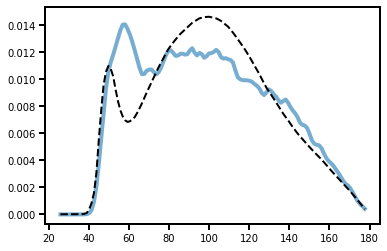

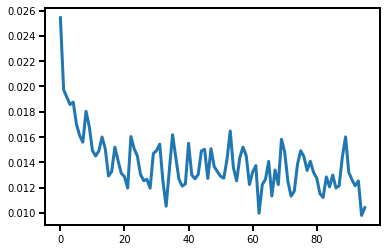

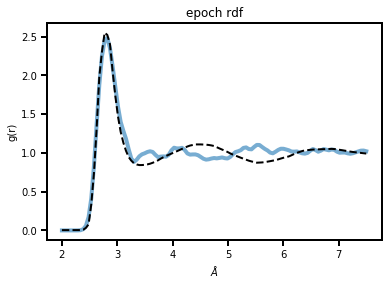

0.013230792246758938 0.004315038211643696
0.013668257743120193 0.0031235171481966972
0.012421401217579842 0.002972603775560856
0.012923750095069408 0.003188522532582283
0.012301255017518997 0.0029291799291968346


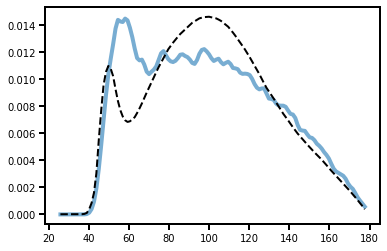

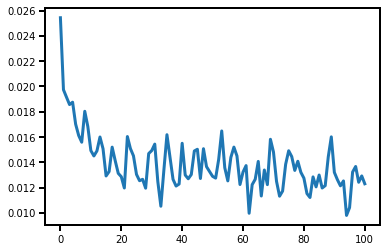

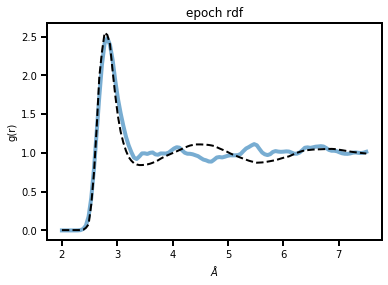

0.013419879600405693 0.0035356413573026657
0.013487495481967926 0.004093877039849758
0.01184229925274849 0.0026555173099040985
0.012616612948477268 0.003343486227095127
0.012729049660265446 0.0036346586421132088


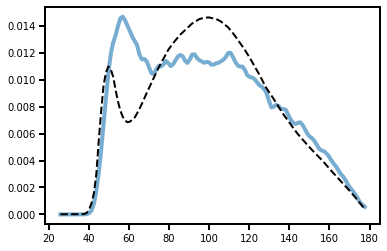

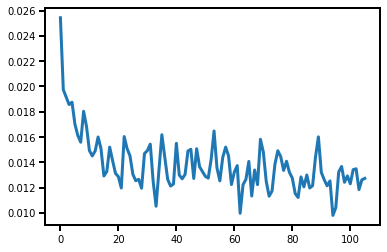

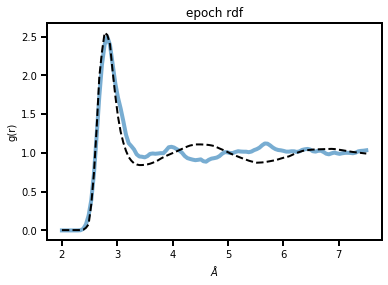

0.014230431988835335 0.0026506762951612473
0.013711024075746536 0.003954783082008362
0.012190325185656548 0.002673031762242317
0.012905263341963291 0.002820308320224285
0.012922261841595173 0.002653716132044792


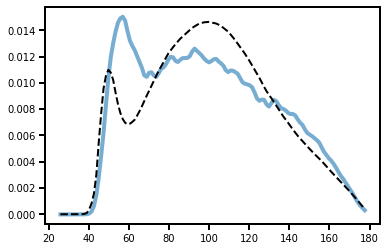

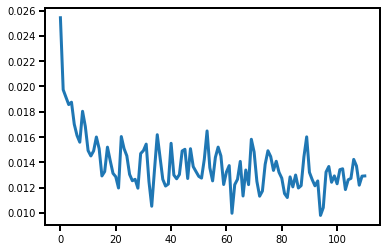

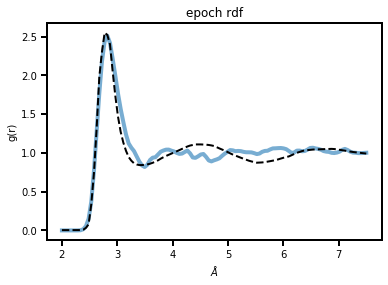

0.012231563217937946 0.003604874014854431
0.009885961189866066 0.002769908867776394
0.010974260978400707 0.003157968632876873
0.013778798282146454 0.002688801847398281
0.013897147960960865 0.004208385944366455


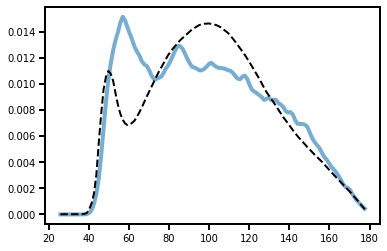

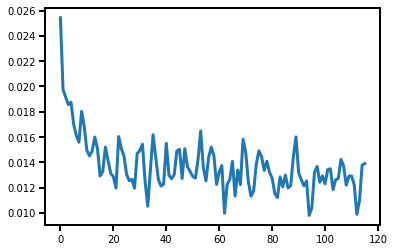

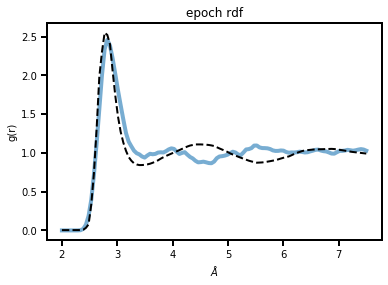

0.013998668640851974 0.003658863715827465
0.013908129185438156 0.0037101348862051964
0.011640533804893494 0.002856840379536152
0.01273566298186779 0.004256034269928932
0.016698136925697327 0.004181734286248684


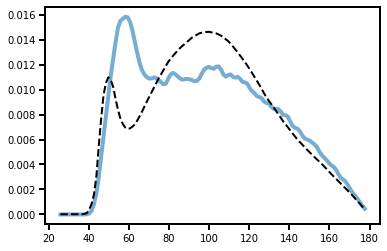

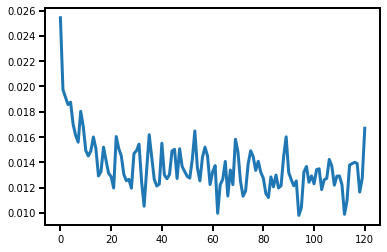

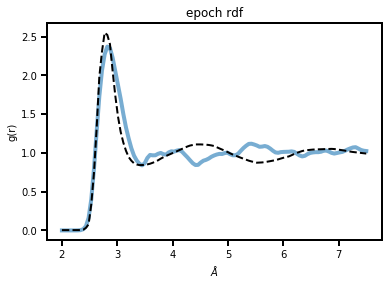

0.014738344587385654 0.003952275961637497
0.013438910245895386 0.002997913397848606
0.012569857761263847 0.0021630190312862396
0.011743353679776192 0.002463855780661106
0.011827334761619568 0.003268859349191189


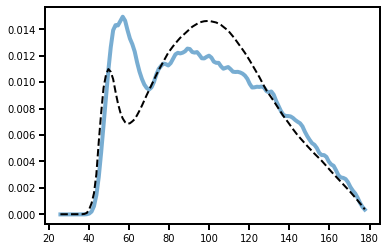

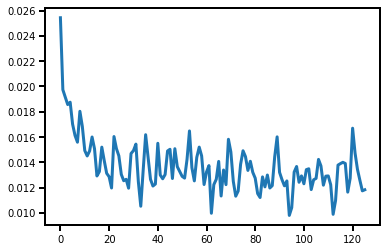

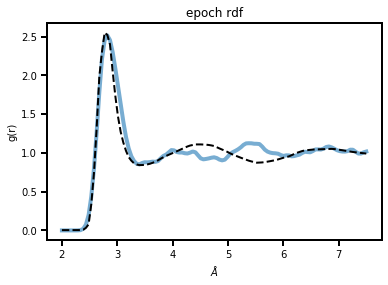

0.01029994897544384 0.002979101613163948
0.014645046554505825 0.003058403730392456
0.013913067057728767 0.003366990014910698
0.01418408751487732 0.003565230406820774
0.013797065243124962 0.003809817135334015


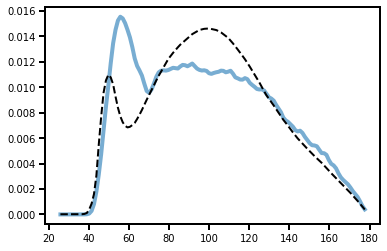

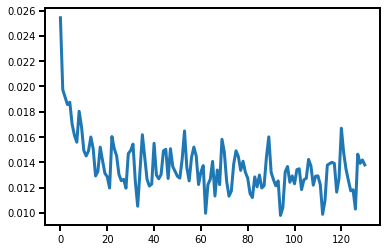

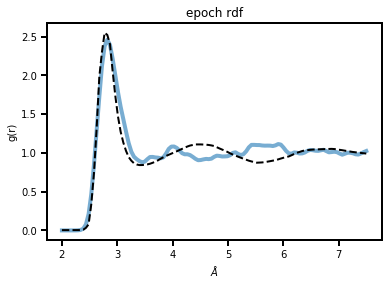

0.01295754685997963 0.003180607222020626
0.012464777566492558 0.003476286306977272
0.012999490834772587 0.0033437060192227364
0.013229005970060825 0.00330421794205904
0.01296139508485794 0.003352210856974125


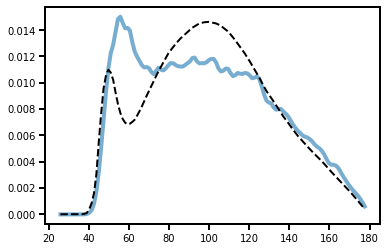

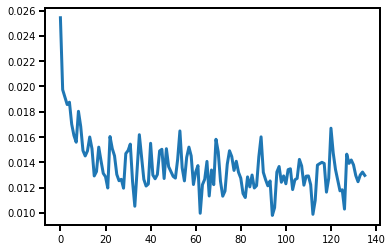

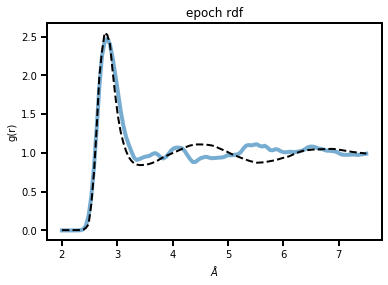

0.013898798264563084 0.0034493450075387955
0.014825455844402313 0.003002268262207508
0.01664300449192524 0.0030349204316735268
0.015908140689134598 0.004378155805170536
0.013868505135178566 0.004150290973484516


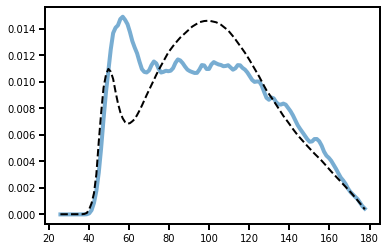

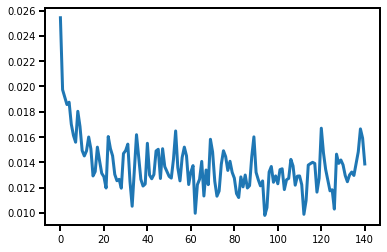

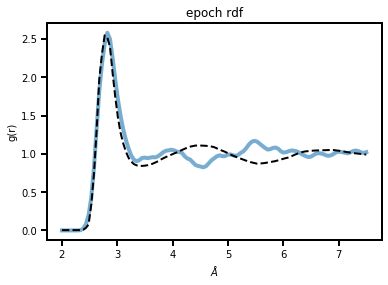

0.011788064613938332 0.002962919883430004
0.01492702029645443 0.0031450754031538963
0.01472404319792986 0.00440873671323061
0.014230869710445404 0.0032257847487926483
0.013629302382469177 0.0031637893989682198


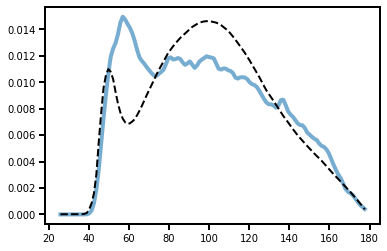

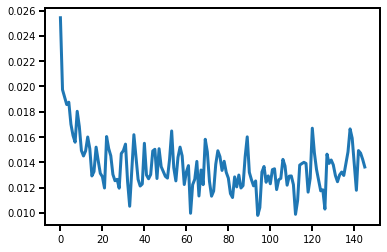

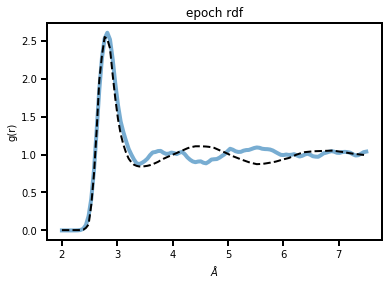

0.013365713879466057 0.002990683540701866
0.013886848464608192 0.003473128192126751
0.014156484976410866 0.0034059621393680573
0.01235856395214796 0.0025005778297781944
0.012882808223366737 0.0031726621091365814


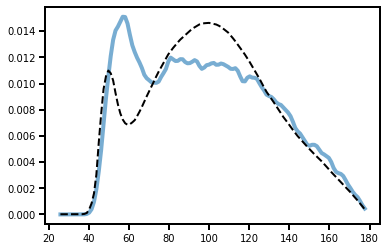

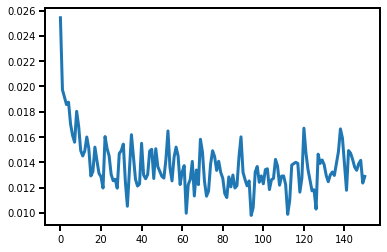

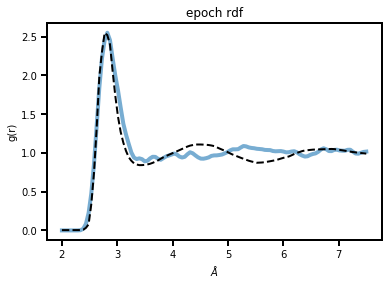

0.013085324317216873 0.0034265313297510147
0.011684209108352661 0.003486127592623234
0.013182972557842731 0.0027024811133742332
0.013543171808123589 0.003052464686334133
0.012860547751188278 0.003252824768424034


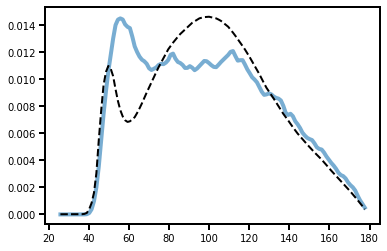

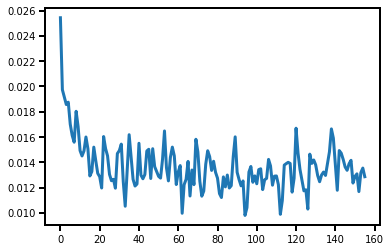

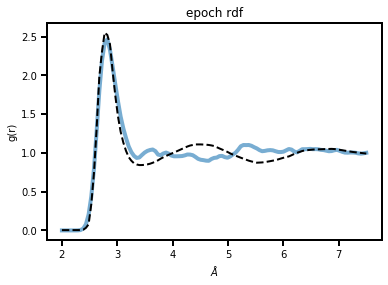

0.015914397314190865 0.004024837166070938
0.012860847637057304 0.0033593522384762764
0.014974471181631088 0.0035048099234700203
0.01584990695118904 0.00412087794393301


RuntimeError: invalid argument 3: out of range at /opt/conda/conda-bld/pytorch_1565272271120/work/aten/src/TH/generic/THTensor.cpp:370

In [23]:
loss_angle_log = []

all_angle = []

# Simulate 
for i in range(500):
    v_t, q_t, pv_t = sim.simulate(steps=50, frequency=50, dt=1.0 *units.fs)
    
    _, bins, g = obs(q_t[::5])

    # this shoud be wrapped in some way 
    loss_js = JS_rdf(g_obs, g)
    loss_rdf = loss_js + 6.7 * (g- g_obs).pow(2).sum()
    
    bins, sim_angle_density, cos = angle_obs_train(q_t[::5])
    loss_angle = (sim_angle_density/ ANGLE_FACTOR - cos_exp_train/ ANGLE_FACTOR).pow(2).mean()
    
    print(loss_angle.item(), loss_js.item())
    
    loss = (loss_angle * 100 + loss_rdf)
    
    loss_angle.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    loss_angle_log.append(loss_angle.item())
    
    all_angle.append(sim_angle_density.detach().cpu())
    
    if i % 5 == 0:
        plot_angle(sim_angle_density, 
           cos_exp_train, cos_start, cos_end,
           "junk", 
           path='../examples/metadta/', 
           nbins_angle=nbins_angle_train)
        
        plt.plot(loss_angle_log)
        plt.show()
        
        plot_rdfs(xnew, g_obs, g, "rdf", '../examples/metadta/')

In [298]:
vec1 = junk[angle_list[:, 0], angle_list[:,1]] - junk[angle_list[:, 0], angle_list[:,2]]

In [303]:
vec1 = vec1 + get_offsets(vec1, cell, device) * cell

(array([ 147.,  939., 2601., 3009., 1845., 1473., 1590., 1254., 1257.,
        1245.]),
 array([2.4250927, 2.5325565, 2.6400201, 2.747484 , 2.8549478, 2.9624114,
        3.0698752, 3.177339 , 3.284803 , 3.3922665, 3.4997303],
       dtype=float32),
 <a list of 10 Patch objects>)

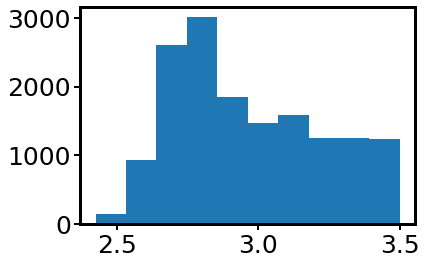

In [308]:
plt.hist( vec1.pow(2).sum(-1).sqrt().detach().cpu().numpy() )

In [146]:
display_traj(system, diffeq.traj)

NGLWidget(max_frame=646)

In [57]:
exp_angle_data(nbins_angle, (cos_start, cos_end))

array([0.40822618, 0.45554822, 0.48936279, 0.52374781, 0.56544536,
       0.59979975, 0.61810237, 0.65938255, 0.69837566, 0.74328885,
       0.78526579, 0.82213165, 0.85832444, 0.90404251, 0.94393369,
       0.96385145, 0.98285025, 1.00322472, 1.01034668, 1.01740367,
       1.02194178, 1.020206  , 1.00420868, 0.97831499, 0.95514654,
       0.93628394, 0.90531815, 0.86859587, 0.82411312, 0.77607497,
       0.72912867, 0.69135452, 0.64696183, 0.60222643, 0.5629857 ,
       0.53087176, 0.50402571, 0.48300321, 0.46260974, 0.44397398])

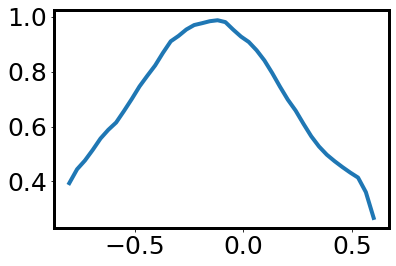

In [52]:
plt.plot(xnew, normed_density)

In [46]:
norm = ((xnew[1] - xnew[0]) * f(xnew)).sum()

In [47]:
norm

0.014421256398122582

In [21]:
r_ji = torch.Tensor([1, 0, 0])
r_jk = torch.Tensor([-1, 0, 0])

In [22]:
x = torch.sum(r_ji * r_jk, dim=-1)
y = torch.cross(r_ji, r_jk)
y = torch.norm(y, dim=-1)
angle = torch.atan2(y, x)


In [23]:
angle

tensor(3.1416)

In [24]:
y

tensor(0.)

In [25]:
angle_dot = (r_ji * r_jk).sum(-1)
norm = ( r_ji.pow(2).sum(-1) * r_jk.pow(2).sum(-1) ).sqrt()
cos = angle_dot / norm

In [26]:
cos.acos()

tensor(3.1416)